# _`Yellowbrick` Model Evaluation_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
# libraries to help us build a function that takes in varying ML algortihms and test their performance
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
import pandas as pd
import os
pd.set_option("display.max_columns", None)

dtype = {
    "id_str": str
}

# load in data specifically created for ML development 
df = pd.read_json("json-data/ml_sample20.json", orient="split")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 0 to 337765
Data columns (total 10 columns):
id_str            337766 non-null int64
screen_name       337766 non-null object
created_at        337766 non-null datetime64[ns]
lang              337766 non-null object
source            337766 non-null object
retweet_count     337766 non-null int64
favorite_count    337766 non-null int64
full_text         337766 non-null object
clean_text        337766 non-null object
label             337766 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 28.3+ MB


In [4]:
# take 20% sample of ML data
sample = df.sample(frac=0.20, random_state=1)

In [5]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67553 entries, 305421 to 229224
Data columns (total 10 columns):
id_str            67553 non-null int64
screen_name       67553 non-null object
created_at        67553 non-null datetime64[ns]
lang              67553 non-null object
source            67553 non-null object
retweet_count     67553 non-null int64
favorite_count    67553 non-null int64
full_text         67553 non-null object
clean_text        67553 non-null object
label             67553 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 5.7+ MB


In [6]:
# reset index of sample
sample = sample.reset_index(drop=True)

In [7]:
# convert label column to cateogry type
sample["label"] = sample["label"].astype("category")

In [8]:
# replace values in label column with 0 for real accounts and 1 for fake accounts
#sample["label"] = sample["label"].replace(to_replace={"real": 0, "fake": 1})

## _t-SNE Corpus Visualization_

In [31]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

stop_words = text.ENGLISH_STOP_WORDS

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer


# fit transform sample_text column
X_tf = TfidfVectorizer().fit_transform(sample["clean_text"])
X_c = CountVectorizer(stop_words=stop_words).fit_transform(sample["clean_text"])
# encode target column
y = LabelEncoder().fit_transform(sample["label"])

In [27]:
vectorizer = CountVectorizer(stop_words=stop_words)
docs = vectorizer.fit_transform(sample["clean_text"])

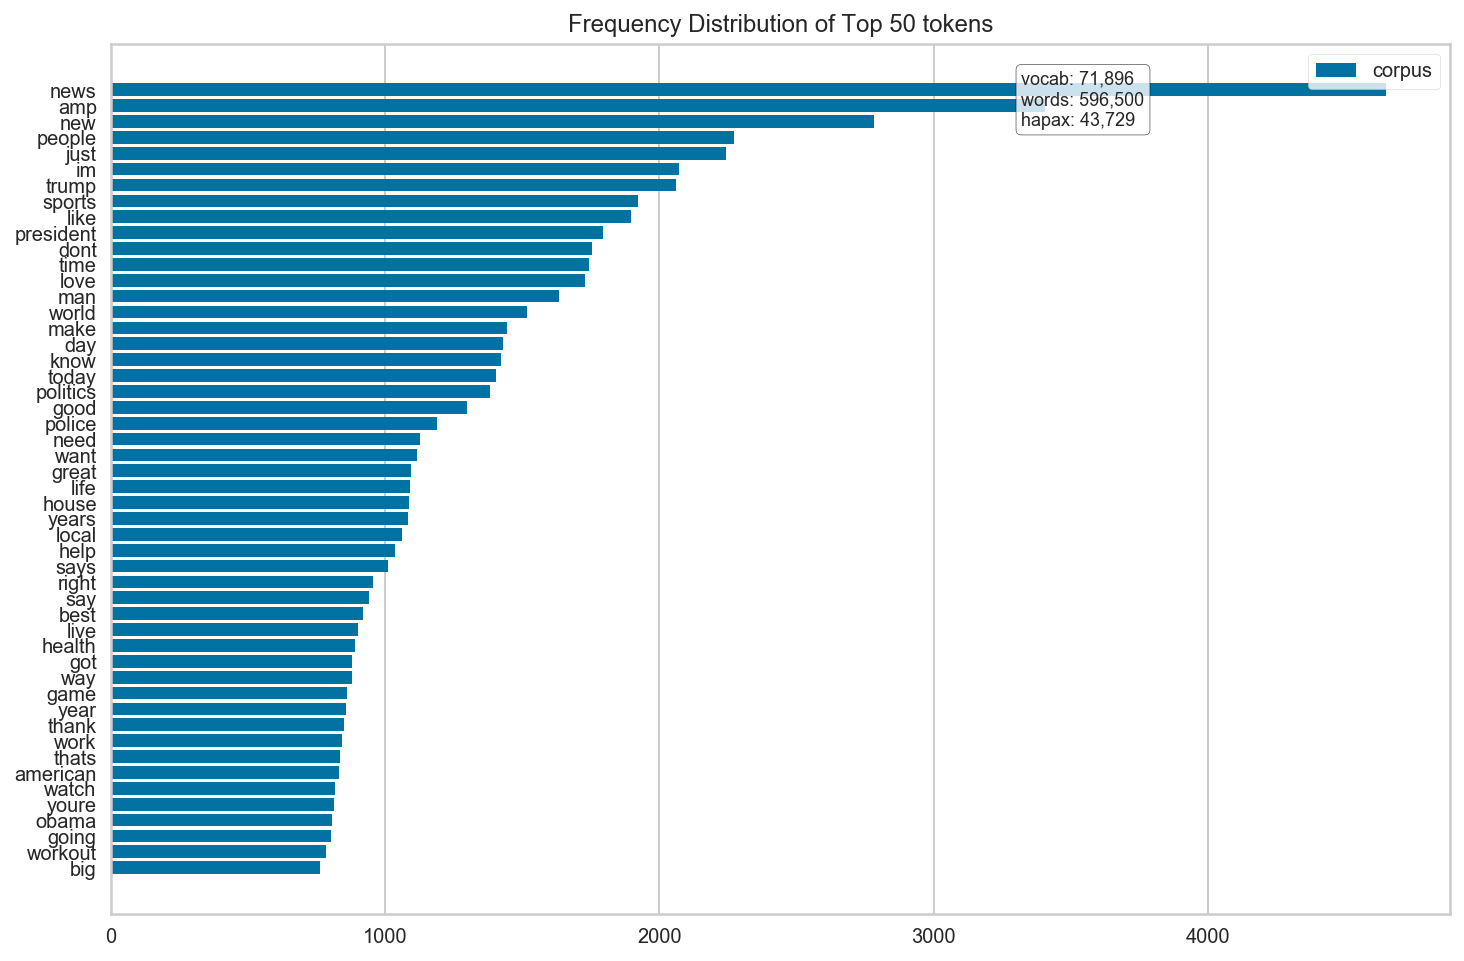

In [32]:
plt.figure(figsize=(12,8))
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

In [13]:
from sklearn.decomposition import TruncatedSVD

X_trunc = TruncatedSVD(random_state=1).fit(X)

In [14]:
from yellowbrick.text import TSNEVisualizer

# create the visualizer and draw vectors
tsne = TSNEVisualizer()
tsne.fit(X_trunc, y)

ValueError: Expected 2D array, got scalar array instead:
array=TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=1,
             tol=0.0).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
tsne.show()

## _Initial Model Evaluation_

In [33]:
naive_bayes = MultinomialNB()
svc = LinearSVC(random_state=1)
rf = RandomForestClassifier(random_state=1, n_estimators=10, n_jobs=-1)
lr = LogisticRegression(random_state=1, solver="lbfgs", max_iter=200)
ada = AdaBoostClassifier(random_state=1)
hist = HistGradientBoostingClassifier(random_state=1)

# create list of models
models = [
    naive_bayes,
    svc,
    lr,
    rf,
    ada
]

def test_models(X, y, model):
    """
    Test various estimators with 5-fold CV, and retrieve F1 Score.
    """
    # encode target column
    y = LabelEncoder().fit_transform(y)
    # define the classifier
    clf = Pipeline([
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", model)
    ]) 
    # perform cross_validation and return f1 scores
    scores = cross_val_score(clf, X, y, cv=5, scoring="f1", n_jobs=-1)
    # print out 95% confidence interval of the score estimate
    return str("%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [34]:
for model in models:
    scores = test_models(sample["clean_text"], sample["label"], model)
    clf_name = str(model).split("(")[0]
    print(f"CV F1 Score for {clf_name}: {scores}")

CV F1 Score for MultinomialNB: 0.85 (+/- 0.01)
CV F1 Score for LinearSVC: 0.85 (+/- 0.01)
CV F1 Score for LogisticRegression: 0.84 (+/- 0.00)
CV F1 Score for RandomForestClassifier: 0.81 (+/- 0.00)
CV F1 Score for AdaBoostClassifier: 0.72 (+/- 0.01)


In [39]:
# clean up text a little bit further and rerun the above
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import re

# Create our list of punctuation marks
punctuations = punctuation

# Create our list of stopwords
stop_words = STOP_WORDS

def test_clean1(text):
    text = re.sub("amp", "and", text)
    text = " ".join(word for word in text.lower().split() if word not in stop_words)
    return text

In [40]:
sample["test_clean1"] = sample["clean_text"].apply(lambda x: test_clean1(x))

In [41]:
for model in models:
    scores = test_models(sample["test_clean1"], sample["label"], model)
    clf_name = str(model).split("(")[0]
    print(f"CV F1 Score for {clf_name}: {scores}")

CV F1 Score for MultinomialNB: 0.85 (+/- 0.01)
CV F1 Score for LinearSVC: 0.86 (+/- 0.01)
CV F1 Score for LogisticRegression: 0.83 (+/- 0.01)
CV F1 Score for RandomForestClassifier: 0.82 (+/- 0.01)
CV F1 Score for AdaBoostClassifier: 0.76 (+/- 0.00)


## _Visualize Model Evaluation via Classification Report_

In [42]:
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import train_test_split

# create function that will return a Classification report for each model
def visualize_classification(X, y, model):
    """
    Function that returns a Yellowbrick classification Report for a given ML 
    estimator.
    """
    # encode target column
    y = LabelEncoder().fit_transform(y)
    
    # split data sample into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=1
    )
    
    # define the classifier
    clf = Pipeline([
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", model)
    ])
    
    encode_dict = {
        0: "Real",
        1: "Fake"
    }
    
    # instantiate classification model and visualizer
    visualizer = ClassificationReport(
        clf, cmap="RdYlGn", encoder=encode_dict,
        size=(600, 360)
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

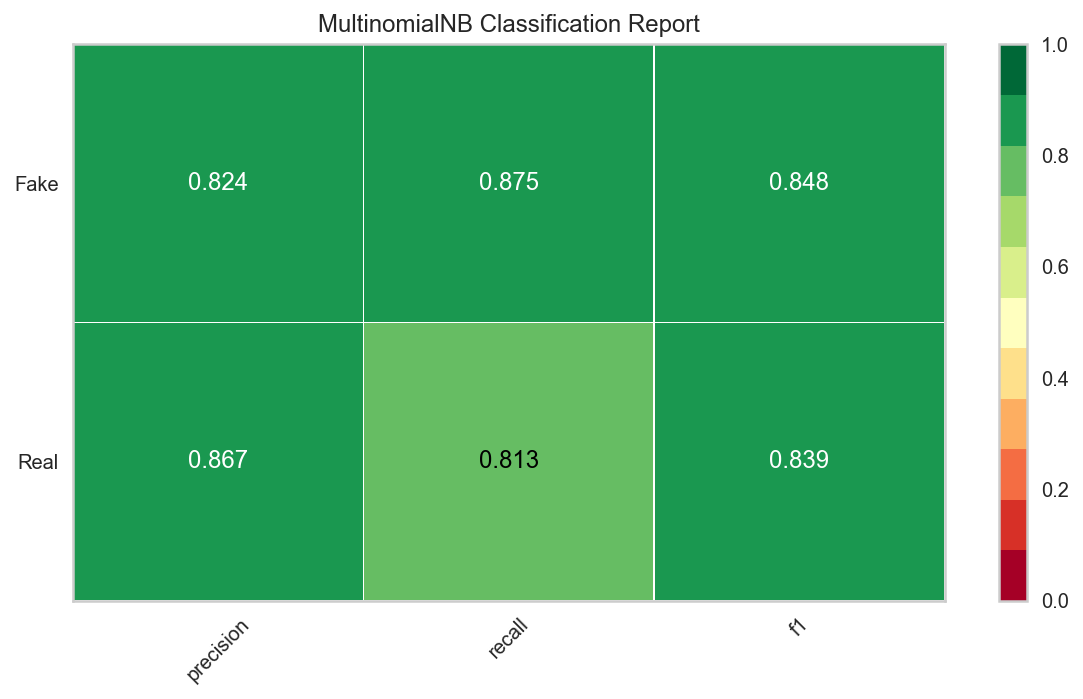

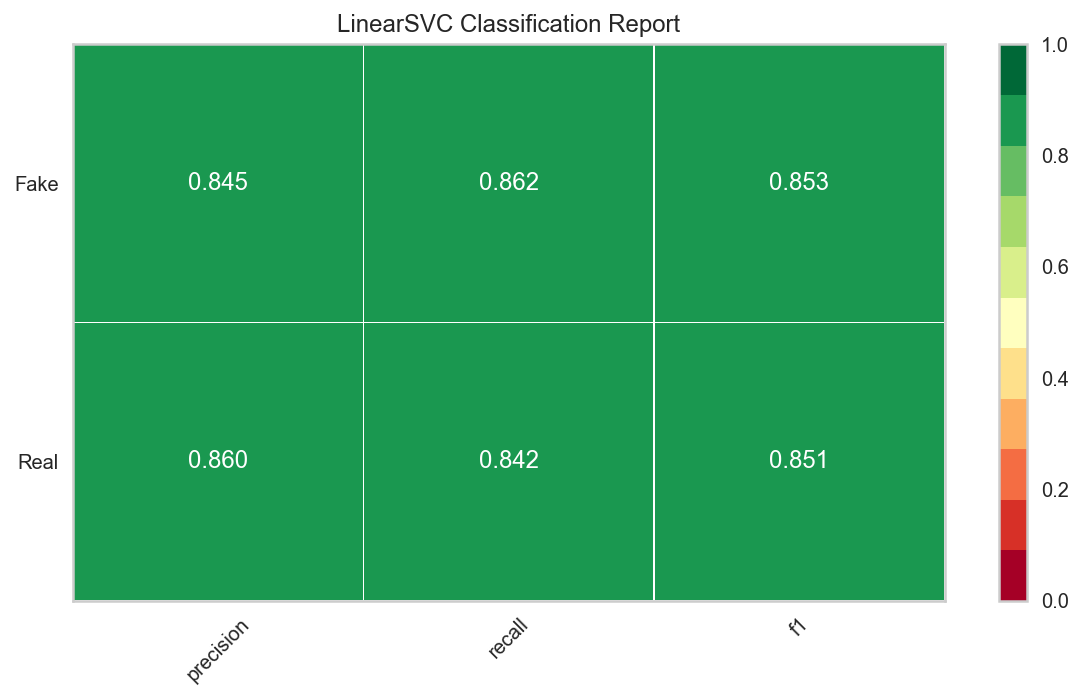

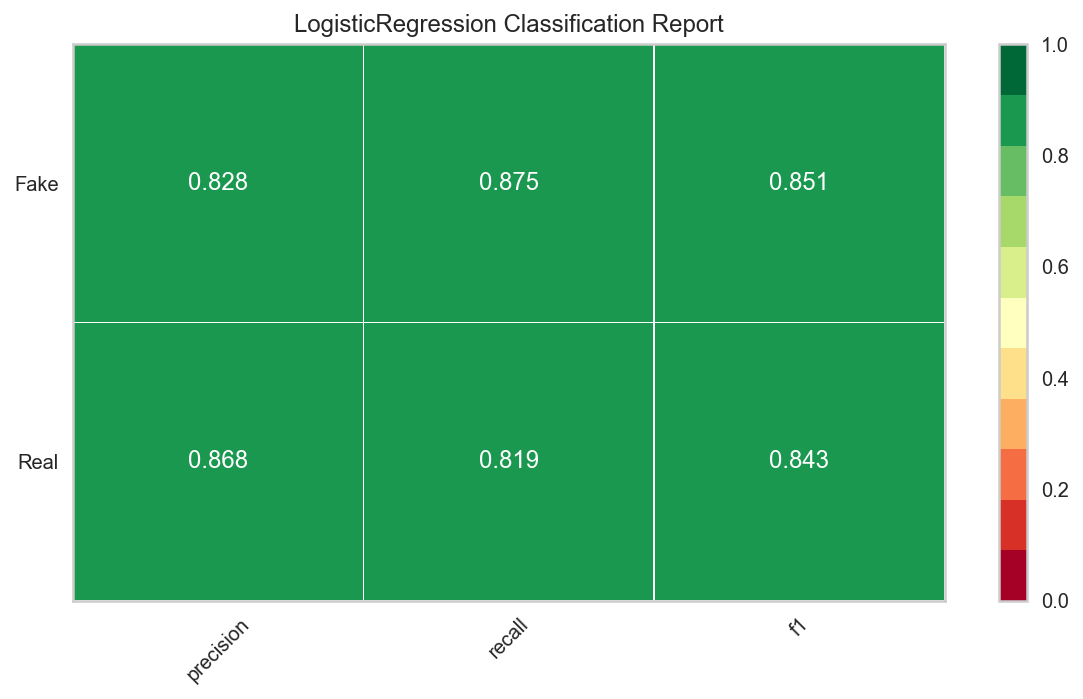

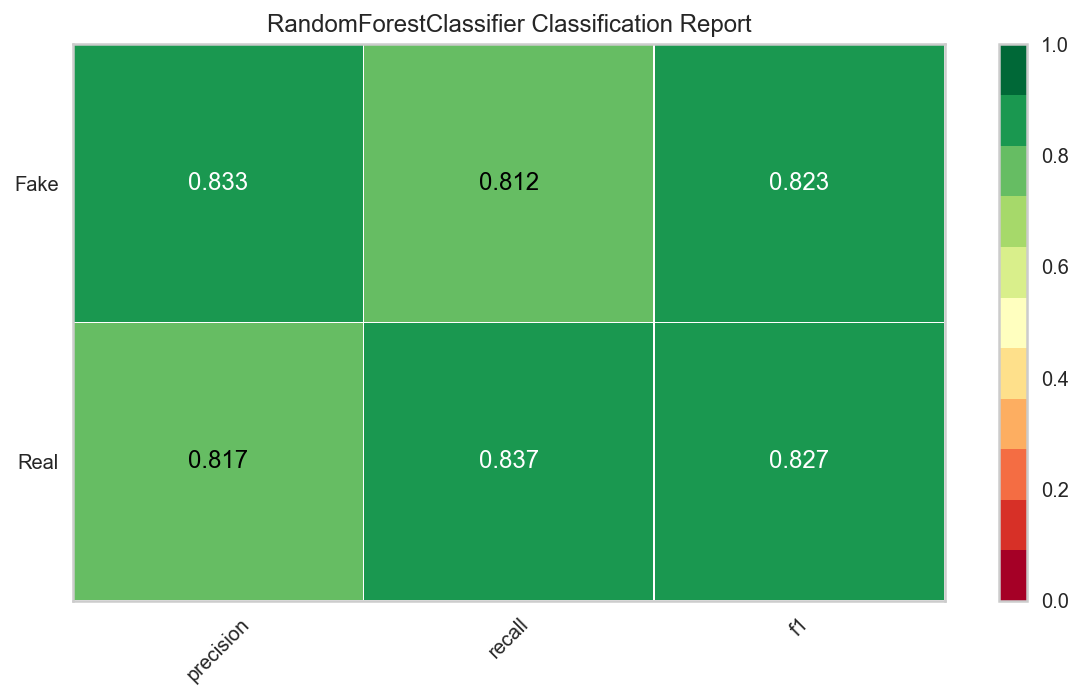

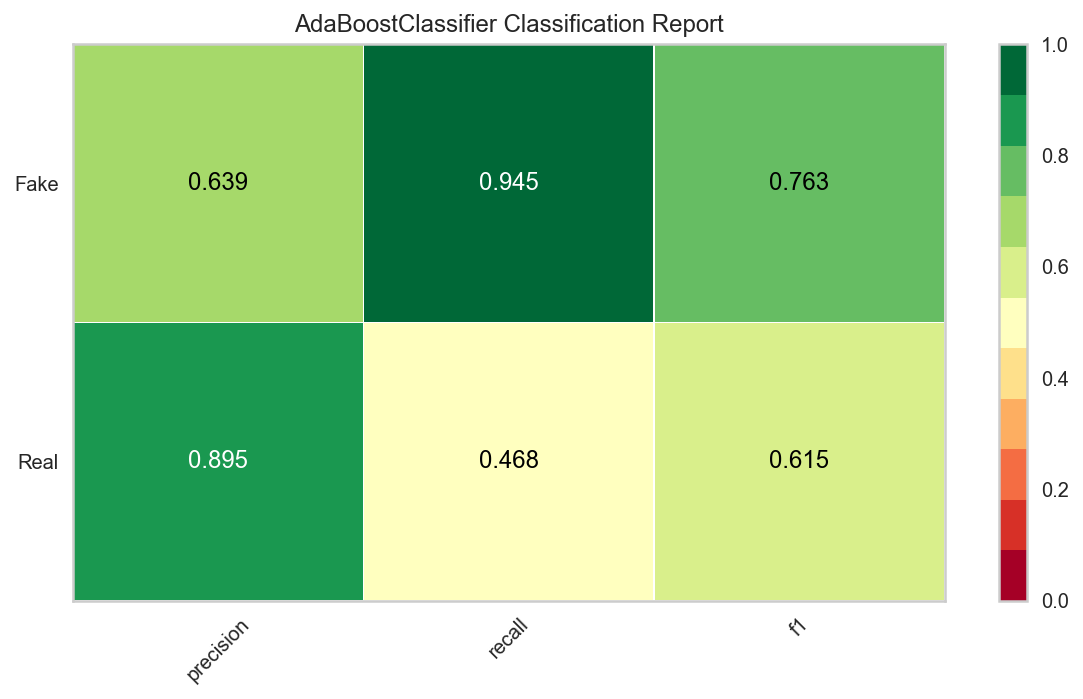

In [43]:
for model in models:
    visualize_classification(sample["test_clean1"], sample["label"], model)

## _Experimentation with `yellowbrick` dataset_

In [ ]:
from yellowbrick.datasets import load_occupancy

In [ ]:
X, y = load_occupancy()

In [ ]:
y

In [ ]:
classes = ["unoccupied", "occupied"]

In [ ]:
visualizer = ClassificationReport(MultinomialNB(), classes=classes)

visualizer.fit(sample[, y)
visualizer.score(X, y)
visualizer.show()